### Extracting features - Finance analysis

### Features Extracted:

- https://github.com/lappis-unb/salic-ml/wiki/Brainstorming-de-features-para-estimar-Complexidade-Financeira
    
Gerar features de um segmento "ESPECÍFICO" e "GLOBAIS".

### Importing data

In [2]:
import os
import sys
import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy import stats


from salicml.utils.dates import Dates
from salicml.utils.read_csv import read_csv


PROJECT_ROOT = os.path.abspath(os.path.join(os.pardir, os.pardir))
DATA_FOLDER = os.path.join(PROJECT_ROOT, 'data', 'raw')

#### PLANILHA ORCAMENTARIA

QUERY: /data/scripts/planilha_orcamentaria.sql


In [3]:
PlanilhaOrcamentaria = 'planilha_orcamentaria.csv'
planilhaOrcamentaria = read_csv(PlanilhaOrcamentaria)

planilhaOrcamentaria.head()

,idPronac,PRONAC,idPlanilhaAprovacao,Item,idPlanilhaItens,Unidade,QtDias,QtItem,nrOcorrencia,VlUnitarioSolicitado,...,UfItem,MunicipioItem,Etapa,idArea,Area,idSegmento,Segmento,idProduto,Produto,DataProjeto
0,114166,93004,50109,Montagem e desmontagem,88,Serviço,2,1.0,2,140.00,...,PB,Sumé,2 - Produção / Execução,5,Patrimônio Cultural,51,História,62,Exposição de Artes,2009-06-26 09:46:54
1,123461,103228,239572,Locação de Piano,3040,Serviço,12,1.0,6,1500.00,...,RJ,Rio de Janeiro,2 - Produção / Execução,3,Música,33,Música Instrumental,51,Apresentação Musical,2010-05-06 10:49:13
2,123461,103228,239599,Programa,2634,Unidade,6,400.0,6,2.00,...,RJ,Rio de Janeiro,3 - Divulgação / Comercialização,3,Música,33,Música Instrumental,51,Apresentação Musical,2010-05-06 10:49:13
3,132803,1012471,86608,Transporte Local / Locação de Automóvel / Comb...,134,Metro 3 / Km,4,500.0,4,1.45,...,MG,Viçosa,2 - Produção / Execução,7,Artes Integradas,71,Artes Integradas,51,Apresentação Musical,2010-12-21 17:09:22
4,115111,93932,11387,Confecção de painéis explicativos,90,Unidade,30,20.0,1,300.00,...,PE,Recife,2 - Produção / Execução,7,Artes Integradas,71,Artes Integradas,62,Exposição de Artes,2009-07-27 08:40:04


##### PLANILHA COMPROVACAO

QUERY: /data/scripts/planilha_comprovacao2.sql

In [4]:
PlanilhaComprovacao = 'planilha_comprovacao_2.csv'
planilhaComprovacao = read_csv(PlanilhaComprovacao)

planilhaComprovacao.head()

,idPlanilhaAprovacao,idComprovantePagamento,IdPRONAC,cdProduto,cdEtapa,cdUF,cdCidade,idPlanilhaItem,nrComprovante,nrSerie,...,dtPagamento,dtEmissao,tpFormaDePagamento,nrDocumentoDePagamento,idArquivo,dsJustificativaProponente,dsOcorrenciaDoTecnico,stItemAvaliado,stAvaliacao,vlComprovacao
0,18552,4326,132451,1,1,35,355030,43,3052,nfse,...,2014-01-16 00:00:00,2013-03-27 00:00:00,Transferencia Bancaria,42501,410880,Elaboração de projeto gráfico do livro.,NaN,4,Aguardando analise,12000.0
1,18553,4332,132451,1,2,35,355030,91,287,nfse,...,2014-01-16 00:00:00,2012-04-30 00:00:00,Transferencia Bancaria,2945,410935,Reportagem e produção de textos para livro.,NaN,4,Aguardando analise,6000.0
2,18554,4755,132451,1,2,35,355030,143,130,nfse,...,2014-01-28 00:00:00,2012-03-16 00:00:00,Transferencia Bancaria,31601,420731,Fotografia artística para o livro.,NaN,4,Aguardando analise,12000.0
3,18555,4334,132451,1,2,35,355030,3204,139,nfse,...,2014-01-16 00:00:00,2013-08-27 00:00:00,Transferencia Bancaria,90201,410939,Tratamento de imagens para o livro.,NaN,4,Aguardando analise,6000.0
4,18556,4327,132451,1,2,35,355030,97,293,nfse,...,2014-01-16 00:00:00,2012-05-04 00:00:00,Transferencia Bancaria,2945,410917,Edição dos textos do livro.,NaN,4,Aguardando analise,8000.0


#### PLANILHA CAPTACAO

QUERY: /data/scripts/planilha_captacao.sql

In [5]:
PlanilhaCaptacao = 'planilha_captacao.csv'
planilhaCaptacao = read_csv(PlanilhaCaptacao)

planilhaCaptacao.head()

,Idcaptacao,Pronac,NumeroRecibo,CgcCpfMecena,TipoApoio,MedidaProvisoria,DtChegadaRecibo,DtRecibo,CaptacaoReal,CaptacaoUfir,logon,isBemServico
0,1,710601,00008,5911608000191,1,2,2008-09-02 00:00:00,2008-07-11 00:00:00,3253.0,3253.0,2437,0
1,2,710601,00009,7483926000124,1,2,2008-09-02 00:00:00,2008-07-11 00:00:00,4427.0,4427.0,2437,0
2,3,710601,00010,3084709000100,1,2,2008-09-02 00:00:00,2008-07-11 00:00:00,5781.0,5781.0,2437,0
3,4,710601,00011,55444095000124,1,2,2008-09-02 00:00:00,2008-07-11 00:00:00,38160.0,38160.0,2437,0
4,5,710601,00012,9794389000169,1,2,2008-09-02 00:00:00,2008-07-11 00:00:00,4436.0,4436.0,2437,0


### FEATURES )
    - Numero de Itens do projeto.
    - Total Comprovado.
    - Total Aprovado.
    - Total Captado.
    - Número de Comprovantes.
    - Numero de fornecedores de cada projeto. (% de fornecedores entre os mais comuns.)


In [6]:
class Receipts:
    def __init__(self, raw_receipts):
        self.all_receipts = raw_receipts     
        
        
    def get_number_of_receipts(self):
        return len(self.all_receipts)

    def get_total_verified_cost(self):
        return sum(self.all_receipts['vlComprovacao'].values)
    
    def get_fornecedores(self):
        suppliers = self.all_receipts.nrCNPJCPF.unique()
        return suppliers


In [7]:
class Captacoes:
    def __init__(self, raw_captacao):
        self.all_captacoes = raw_captacao     
        
    def get_total_real_raised_funds(self):
        return sum(self.all_captacoes['CaptacaoReal'].values) # "CaptacaoReal","CaptacaoUfir"
    

In [8]:
class Items:
    def __init__(self, raw_items):
        self.all_items = raw_items
        
    
    def get_number_of_items(self):
        return self.all_items.shape[0]

    def get_quantity_of_items(self):
        quantity_of_items =  sum(self.all_items.QtItem * self.all_items.nrOcorrencia)
        return quantity_of_items
    
    def get_total_approved_cost(self):
        total_cost = sum(self.all_items.VlTotalAprovado)
        return total_cost
    
    def planilha_aprovacao_list(self):
        id_planilha_aprovacao = self.all_items['idPlanilhaAprovacao']
        return id_planilha_aprovacao.values

In [9]:
class Project:
    def __init__(self, raw_project, raw_receipts, raw_captacoes):
        self.raw_project      = raw_project
        self.raw_receipts = raw_receipts
        self.raw_captacoes    = raw_captacoes
        
        self.pronac = self.setPronac()
        
        self.items = Items(self.setItemsList())
        self.receipts = Receipts(self.raw_receipts)
        self.captacoes = Captacoes(self.raw_captacoes)
        
        self.segment = self.setSegment()
        self.area = self.setArea()
        self.project_data = self.setProjetoData()
        
    def setItemsList(self):
        return self.raw_project.drop(['idPronac', 'PRONAC', 'Area', 'idArea','Segmento', 'idSegmento', 'DataProjeto'], axis=1)
    
    def setSegment(self):
        return [self.raw_project['Segmento'].iloc[0],self.raw_project['idSegmento'].iloc[0]]

    def setArea(self):
        return [self.raw_project['Area'].iloc[0],self.raw_project['idArea'].iloc[0]]
      
    def setPronac(self):
        return [self.raw_project['PRONAC'].iloc[0], self.raw_project['idPronac'].iloc[0]]

    def setProjetoData(self):
        return self.raw_project['DataProjeto'].iloc[0]
        
    

In [10]:
class ProjectsList:
    
    def __init__(self, planilhaOrcamentaria, planilhaComprovacao, planilhaCaptacao):
        self.planilhaOrcamentaria = planilhaOrcamentaria
        self.planilhaComprovacao = planilhaComprovacao
        self.planilhaCaptacao = planilhaCaptacao
        
        self.pronac_list = []
        # self.loaded_projects_list = []
        self.loaded_projects = {}
        

    # CREATE LIST OF ALL PRONAC's
    def createPronacList(self):
        return self.planilhaOrcamentaria.PRONAC.unique()
    
    # Array of tuples: [(filter1,value1),(filter2,value2)]
    def createPronacListForFilteredProjects(self, filters_and_values):
        filtered_pronacs = []
        for (filtered_column, filter_value) in filters_and_values:
            filtered_projects = self.planilhaOrcamentaria[self.planilhaOrcamentaria[filtered_column] == filter_value]
            if (len(filtered_projects) > 0):
                filtered_pronacs = filtered_projects.PRONAC.unique()
        return filtered_pronacs
    
    # GET SINGLE PROJECT BY PRONAC
    def getUnloadedProject(self, pronac):
        raw_project = self.planilhaOrcamentaria.loc[self.planilhaOrcamentaria['PRONAC'] == pronac]
        raw_receipts = self.planilhaComprovacao.loc[self.planilhaComprovacao['IdPRONAC'] == raw_project['idPronac'].iloc[0]]
        raw_captacoes = self.planilhaCaptacao.loc[self.planilhaCaptacao['Pronac'] == pronac]
        project = Project(raw_project, raw_receipts, raw_captacoes)
        return project

    
    # LOAD ALL PROJECTS
    def loadAllProjects(self):
        pronac_list = self.createPronacList()
        self.pronac_list = []
        
        for [i,pronac] in enumerate(pronac_list):
            # print('loading: ', i, ' / ', len(self.pronac_list))
            #self.loaded_projects_list.append(pronac)
            self.loaded_projects[pronac] = self.getUnloadedProject(pronac);
            self.pronac_list.append(pronac)
            
            # AVOID LOADING ALL PROJECTS.
            if i == 1000:
                break;

    # LOAD ALL PROJECTS
    def loadFilteredProjects(self, filters_and_values):
        pronac_list = self.createPronacListForFilteredProjects(filters_and_values)
        self.pronac_list = []
        
        for [i,pronac] in enumerate(pronac_list):
            # print('loading: ', i, ' / ', len(self.pronac_list))
            #self.loaded_projects_list.append(pronac)

            self.loaded_projects[pronac] = self.getUnloadedProject(pronac)
            self.pronac_list.append(pronac)
            
            # AVOID LOADING ALL PROJECTS.
            if i == 1000:
                break;

    # GET SINGLE PROJECT BY PRONAC
    def loadSingleProject(self, pronac):
        self.pronac_list = [pronac]
        #self.loaded_projects_list = [self.loaded_projects[pronac]]
        self.loaded_projects[pronac] = self.getUnloadedProject(pronac)
        return self.loaded_projects[pronac]



In [11]:
# projectList = ProjectsList(planilhaOrcamentaria, planilhaComprovacao, planilhaCaptacao)
# projectList.loadAllProjects()

#projectList.loadFilteredProjects([('PRONAC', 111986)])
#projectList.loaded_projects[projectList.pronac_list[0]].items.all_items

In [12]:
# allprojects = projectList.loaded_pronacs

# for project in allprojects:
#     projectTest = projectList.getLoadedProject(project)
#     print(projectTest.pronac)
    

proj = ProjectsList(planilhaOrcamentaria, planilhaComprovacao, planilhaCaptacao).loadSingleProject(172085)

# ************** PROJETO **************
# proj.area
# proj.project_data
# proj.segment
# proj.pronac

# ************** COMPROVANTES **************
# proj.receipts.all_receipts
# proj.receipts.get_number_of_receipts()
# proj.receipts.get_total_verified_cost()
# proj.receipts.get_fornecedores()

# ************** ITEMS **************
# proj.items.all_items
# proj.items.get_number_of_items()
# proj.items.get_quantity_of_items()
# proj.items.get_total_approved_cost()

# ************** CAPTACAO **************
# proj.captacoes.get_total_real_raised_funds()

### Filter projects

In [13]:
# projectList = ProjectsList(planilhaOrcamentaria, planilhaComprovacao, planilhaCaptacao)


# proj = projectList.loadSingleProject(172085)

# segmento_projeto = proj.segment[1]
# print('Segmento: ', segmento_projeto)

projectList = ProjectsList(planilhaOrcamentaria, planilhaComprovacao, planilhaCaptacao)

projectList.loadFilteredProjects([('idSegmento', '11')])
pronacs = projectList.pronac_list

# print(len(pronacs))
# print(pronacs)
# print('Itens:')
# for [i,pronac] in enumerate(pronacs):
#     print(i,')')
#     num_of_items = projectList.loaded_projects[pronac].items.get_number_of_items()
#     print(num_of_items)
    
a = [projectList.loaded_projects[pronac].items.get_number_of_items() for pronac in pronacs]


(array([ 37., 111., 181., 237., 171.,  84.,  72.,  31.,  23.,  11.,   5.,
         10.,   5.,   6.,   5.,   2.,   2.,   2.,   1.,   2.,   0.,   1.,
          0.,   0.,   0.,   1.,   0.,   0.,   0.,   1.]),
 array([  6.        ,  17.63333333,  29.26666667,  40.9       ,
         52.53333333,  64.16666667,  75.8       ,  87.43333333,
         99.06666667, 110.7       , 122.33333333, 133.96666667,
        145.6       , 157.23333333, 168.86666667, 180.5       ,
        192.13333333, 203.76666667, 215.4       , 227.03333333,
        238.66666667, 250.3       , 261.93333333, 273.56666667,
        285.2       , 296.83333333, 308.46666667, 320.1       ,
        331.73333333, 343.36666667, 355.        ]),
 <a list of 30 Patch objects>)

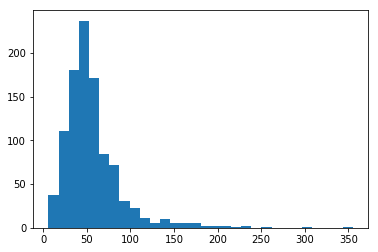

In [14]:
import scipy
import matplotlib.pyplot as plt


plt.hist(a,bins=30)

# mean = np.mean(a)
# var  = np.var(a)

# print(mean)
# print(var)

# scipy.stats.norm(mean, var**.5).cdf(mean + 1.5*var**.5)



# norm(mean=mean, std=var)

**Calculando a probabilidade de um determinado número ser outlier**

Assumindo que a distribuição do número de itens de todos os projetos seja Gaussiana, e dada a média e o desvio padrão desta população, a função abaixo calcula a probabilidade de um determinado número estar no intervalo [0, média + c * desvio_padrão] destra distribuição.

Por exemplo, para o valor `c = 1.5` a probabilidade de um valor `x` qualquer estar no intervalo `[0, média + 1.5 * desvio_padrão]` é de `~ 0.93`. O valor desta probabilidade independe dos valores `média, desvio padrão`.

In [15]:
from math import pi as PI
from salicml.outliers import gaussian_outlier

print(gaussian_outlier.outlier_probability(100, 50000, c = 1.5))

0.9331927987311419


# Feature: Número total de itens

In [16]:
def is_project_num_items_outlier(pronac):
    projectList = ProjectsList(planilhaOrcamentaria, planilhaComprovacao, planilhaCaptacao)

    project = projectList.loadSingleProject(pronac)
    segment, segment_id = project.segment
    project_num_items = project.items.get_number_of_items()
    print(project_num_items)
    
    projectList.loadFilteredProjects([('idSegmento', segment_id)])
    pronacs = projectList.pronac_list

    projects_number_of_items = [projectList.loaded_projects[pronac].items.get_number_of_items() for pronac in pronacs]
    
    mean = np.mean(projects_number_of_items)
    #variance = np.var(projects_number_of_items)
    std = np.std(projects_number_of_items)
    
    is_outlier = gaussian_outlier.is_outlier(project_num_items, mean, std, 1.5)
    return is_outlier

pronac = 172085

p = is_project_num_items_outlier(pronac)
print('local outlier probability = {}'.format(p))

123
local outlier probability = False


# Feature: Total do valor captado

total raised = 4650000.0
projects_raised_funds = [2900000.    720000.   4751640.   8082305.   1825000.   4650000.
  100000.   2680000.    200000.   3295951.32  130000.    331000.
 3500000.    295000.    215000.   2200000.   1800000.    130000.
  300000.   1340000.   1651400.   1450000.  ]
mean = 1933968.0145454546
std = 1964638.2928505877
Is total raised an outlier: = False


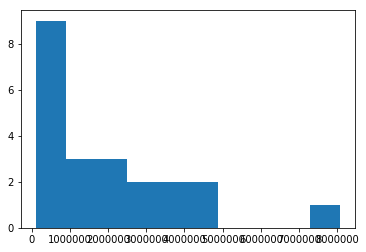

In [37]:
def is_project_total_raised_outlier(pronac):
    projectList = ProjectsList(planilhaOrcamentaria, planilhaComprovacao, planilhaCaptacao)

    project = projectList.loadSingleProject(pronac)
    segment, segment_id = project.segment
    
    total_raised = project.captacoes.get_total_real_raised_funds()
    print('total raised = {}'.format(total_raised))
    
    projectList.loadFilteredProjects([('idSegmento', segment_id)])
    pronacs = projectList.pronac_list

    projects_raised_funds = np.array([projectList.loaded_projects[pronac].captacoes.get_total_real_raised_funds()
                             for pronac in pronacs])
    projects_raised_funds = projects_raised_funds[projects_raised_funds != 0]
    
    print('projects_raised_funds = {}'.format(projects_raised_funds))

    mean = np.mean(projects_raised_funds)
    std = np.std(projects_raised_funds)
    
    print('mean = {}'.format(mean))
    print('std = {}'.format(std))

    is_outlier = gaussian_outlier.is_outlier(total_raised, mean, std, 1.5)
    return (is_outlier, projects_raised_funds)

pronac = 172085

p, raised_funds = is_project_total_raised_outlier(pronac)
print('Is total raised an outlier: = {}'.format(p))
plt.hist(raised_funds)
plt.show()

### Devemos considerar no cálculo da média e desvio padrão projetos com total captado = 0?

Projetos com total captado = 0 diminuem bastante o valor da média, o que enviesa projetos com total captado > 0 a serem outliers.

### Total do valor comprovado do projeto

total verified = 2239933.21
projects_verified_funds = [  37754.    182259.13 2239933.21 2680691.04  126884.5  1430027.13]
mean = 1116258.1683333332
std = 1066374.892711478
Is total verified an outlier: = False


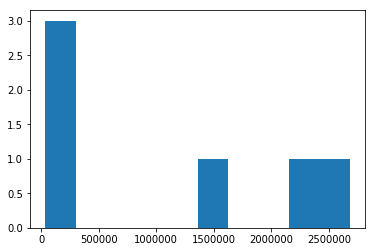

In [40]:
def is_project_total_verified_outlier(pronac):
    projectList = ProjectsList(planilhaOrcamentaria, planilhaComprovacao, planilhaCaptacao)

    project = projectList.loadSingleProject(pronac)
    segment, segment_id = project.segment
    
    total_verified = project.receipts.get_total_verified_cost()
    print('total verified = {}'.format(total_verified))
    
    projectList.loadFilteredProjects([('idSegmento', segment_id)])
    pronacs = projectList.pronac_list

    projects_verified_funds = np.array([projectList.loaded_projects[pronac].receipts.get_total_verified_cost()
                             for pronac in pronacs])
    projects_verified_funds = projects_verified_funds[projects_verified_funds != 0]
    
    print('projects_verified_funds = {}'.format(projects_verified_funds))

    mean = np.mean(projects_verified_funds)
    std = np.std(projects_verified_funds)
    
    print('mean = {}'.format(mean))
    print('std = {}'.format(std))

    is_outlier = gaussian_outlier.is_outlier(total_verified, mean, std, 1.5)
    return (is_outlier, projects_verified_funds)

pronac = 172085

p, verified_funds = is_project_total_verified_outlier(pronac)
print('Is total verified an outlier: = {}'.format(p))
plt.hist(verified_funds)
plt.show()

### Total do valor aprovado do projeto

### Most common items of a given segment

### Most common suppliers of a given segment/state

### Generating Features Dataset